In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import pandas as pd
from torchvision.transforms import InterpolationMode

In [2]:
# Custom Dataset class for the new structure
class DrowsinessCSV_Dataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.transform = transform

        # Locate the CSV file
        csv_files = [f for f in os.listdir(folder_path) if f.endswith("_classes.csv")]
        assert len(csv_files) == 1, "Expected one _classes.csv file per folder"
        csv_path = os.path.join(folder_path, csv_files[0])

        # Load labels
        df = pd.read_csv(csv_path)
        self.image_paths = []
        self.labels = []

        for _, row in df.iterrows():
            filename = row['filename']
            label = int(row['1'])  # if 1 column is 1, class is 1 (drowsy), else 0 (alert)
            self.image_paths.append(os.path.join(folder_path, filename))
            self.labels.append(label)

        print(f"Loaded {len(self.image_paths)} samples from {folder_path}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [3]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Load pretrained ViT model and feature extractor
pretrained_vit_weights = torchvision.models.ViT_L_16_Weights.DEFAULT
pretrained_vit = torchvision.models.vit_l_16(weights=pretrained_vit_weights).to(device)

In [5]:
# Unfreeze some layers for fine-tuning
for name, parameter in pretrained_vit.named_parameters():
    if "encoder" in name:  # Fine-tune the encoder layers
        parameter.requires_grad = True

In [6]:
# Replace classification head for 2-class prediction
pretrained_vit.heads = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(in_features=1024, out_features=2)
).to(device)

In [7]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [8]:
# Dataset root path
root_dir = "./Drowsiness-/-Fatigue_Detection-4"
train_dataset = DrowsinessCSV_Dataset(os.path.join(root_dir, "train"), transform=train_transform)
val_dataset = DrowsinessCSV_Dataset(os.path.join(root_dir, "valid"), transform=val_transform)

Loaded 9638 samples from ./Drowsiness-/-Fatigue_Detection-4/train
Loaded 814 samples from ./Drowsiness-/-Fatigue_Detection-4/valid


In [9]:
# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

In [10]:
# Optimizer
optimizer = optim.AdamW([
    {'params': pretrained_vit.heads.parameters(), 'lr': 1e-3},
    {'params': [param for name, param in pretrained_vit.named_parameters() if "encoder" in name], 'lr': 1e-4}
], weight_decay=1e-4)

# Scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Loss function
criterion = nn.CrossEntropyLoss()

In [17]:
# Training loop
epochs = 25
best_val_accuracy = 0.0
epochs_no_improve = 0
early_stopping_patience = 5

for epoch in range(epochs):
    pretrained_vit.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = pretrained_vit(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        correct_predictions += torch.sum(preds == labels).item()
        total_predictions += labels.size(0)

    epoch_loss = running_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    # Validation phase
    pretrained_vit.eval()
    val_correct_predictions = 0
    val_total_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = pretrained_vit(inputs)
            preds = torch.argmax(outputs, dim=1)
            val_correct_predictions += torch.sum(preds == labels).item()
            val_total_predictions += labels.size(0)

    val_accuracy = val_correct_predictions / val_total_predictions
    print(f"Validation Accuracy: {val_accuracy:.4f}")

    scheduler.step(val_accuracy)

    # Early stopping
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        epochs_no_improve = 0
        torch.save(pretrained_vit.state_dict(), 'best_vitl_drowsy2class.pth')
        print("New best model saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= early_stopping_patience:
        print("Early stopping triggered. Training stopped.")
        break

print("Training complete!")

Epoch [1/25], Loss: 0.3954, Accuracy: 0.8077
Validation Accuracy: 0.9459
New best model saved.
Epoch [2/25], Loss: 0.2738, Accuracy: 0.8842
Validation Accuracy: 0.9631
New best model saved.
Epoch [3/25], Loss: 0.2517, Accuracy: 0.8941
Validation Accuracy: 0.9607
Epoch [4/25], Loss: 0.2368, Accuracy: 0.8996
Validation Accuracy: 0.9472
Epoch [5/25], Loss: 0.2090, Accuracy: 0.9156
Validation Accuracy: 0.9607
Epoch 00005: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00005: reducing learning rate of group 1 to 5.0000e-05.
Epoch [6/25], Loss: 0.1513, Accuracy: 0.9370
Validation Accuracy: 0.9386
Epoch [7/25], Loss: 0.1287, Accuracy: 0.9475
Validation Accuracy: 0.9423
Early stopping triggered. Training stopped.
Training complete!


In [18]:
# Load the best model
pretrained_vit.load_state_dict(torch.load('best_vitl_drowsy2class.pth'))
pretrained_vit.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

In [13]:
# Prepare test dataset and dataloader
test_dataset = DrowsinessCSV_Dataset(os.path.join(root_dir, "test"), transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

Loaded 482 samples from ./Drowsiness-/-Fatigue_Detection-4/test


In [14]:
# Testing phase
all_labels, all_preds = [], []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = pretrained_vit(inputs)
        all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [15]:
# Import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Test Accuracy: 0.9730
Precision: 0.9744
Recall: 0.9730
F1 Score: 0.9735
Classification Report:
               precision    recall  f1-score   support

       alert       0.86      0.93      0.89        58
      drowsy       0.99      0.98      0.98       424

    accuracy                           0.97       482
   macro avg       0.92      0.95      0.94       482
weighted avg       0.97      0.97      0.97       482



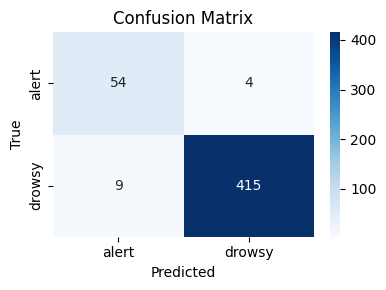

In [22]:
# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate and print classification report
print("Classification Report:\n", classification_report(all_labels, all_preds, target_names=['alert', 'drowsy']))

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['alert', 'drowsy'], 
            yticklabels=['alert', 'drowsy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()